Preview of cleaned streams column:
0    141381703
1    133716286
2    140003974
3    800840817
4    303236322
Name: streams, dtype: int64
Nodes (artists): 699, Edges (collaborations): 707
 Top 10 artists by centrality: [('Metro Boomin', 0.03008595988538682), ('Bad Bunny', 0.027220630372492834), ('Feid', 0.027220630372492834), ('The Weeknd', 0.022922636103151862), ('Quevedo', 0.02148997134670487), ('Peso Pluma', 0.01862464183381089), ('Duki', 0.01862464183381089), ('Kendrick Lamar', 0.01862464183381089), ('De La Ghetto', 0.01862464183381089), ('Tiago pzk', 0.015759312320916905)]


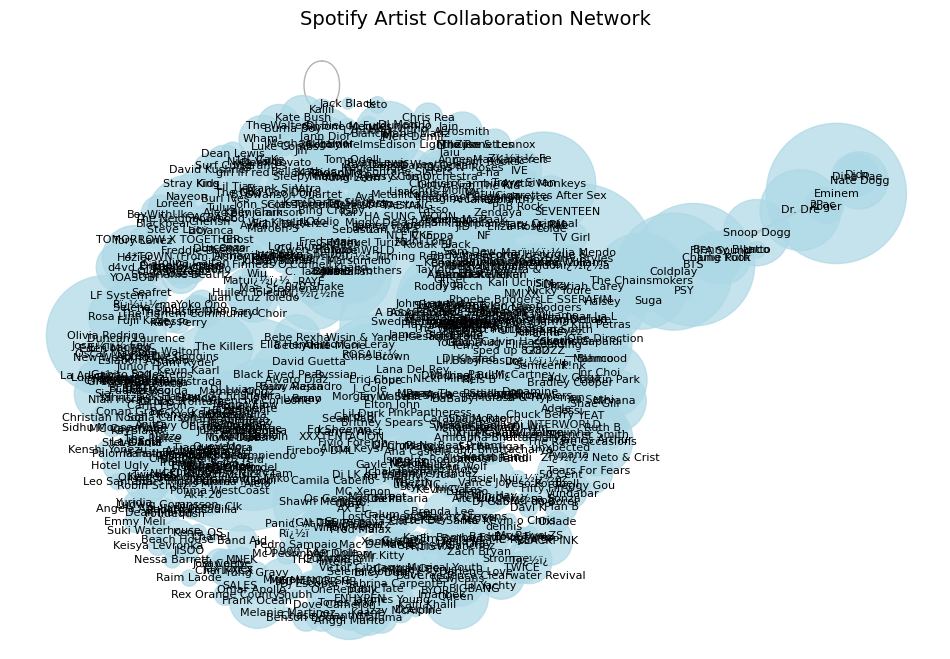

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


spotify_df = pd.read_csv("Spotify Most Streamed Songs.csv")

spotify_df["streams"] = (
    spotify_df["streams"].astype(str).str.replace(",", "", regex=False)
)
spotify_df["streams"] = pd.to_numeric(spotify_df["streams"], errors="coerce").fillna(0).astype(int)

print("Preview of cleaned streams column:")
print(spotify_df["streams"].head())

G = nx.Graph()

for _, row in spotify_df.iterrows():
    artists = [a.strip() for a in str(row["artist(s)_name"]).split(",")]
    streams = row["streams"]

    for artist in artists:
        if artist not in G:
            G.add_node(artist, streams=0)
        G.nodes[artist]["streams"] += streams

    for i in range(len(artists)):
        for j in range(i + 1, len(artists)):
            a, b = artists[i], artists[j]
            if G.has_edge(a, b):
                G[a][b]["weight"] += 1
            else:
                G.add_edge(a, b, weight=1)

print(f"Nodes (artists): {G.number_of_nodes()}, Edges (collaborations): {G.number_of_edges()}")

degree_centrality = nx.degree_centrality(G)
top_artists = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print(" Top 10 artists by centrality:", top_artists)

plt.figure(figsize=(12, 8))
node_sizes = [G.nodes[node]["streams"] / 1e6 for node in G.nodes()]  # scale by millions of streams
edge_weights = [G[u][v]["weight"] for u, v in G.edges()]

pos = nx.spring_layout(G, k=0.3, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="lightblue", alpha=0.7)
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Spotify Artist Collaboration Network", fontsize=14)
plt.axis("off")
plt.show()


🎵 Subgraph: 124 nodes, 255 edges


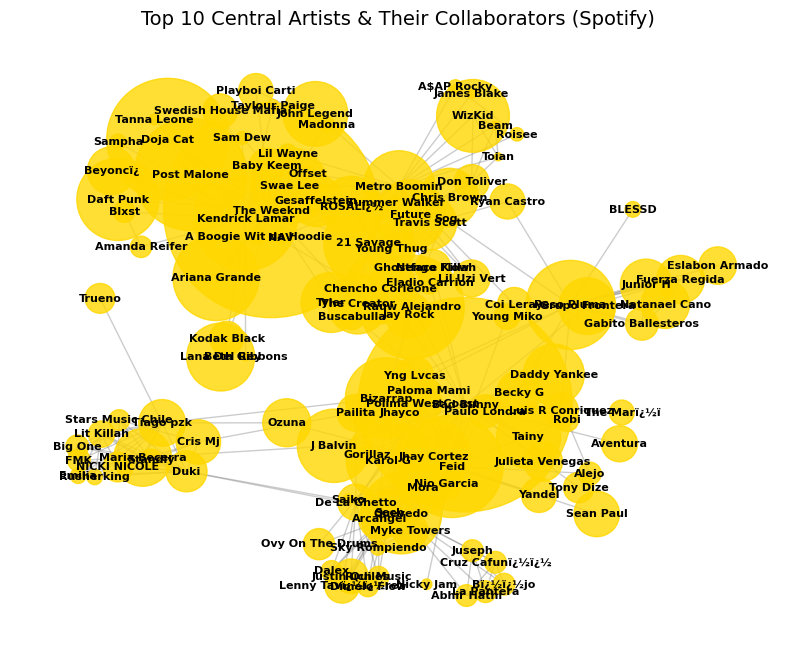

In [5]:
top10_artists = [artist for artist, _ in top_artists]
nodes_to_keep = set(top10_artists)
for artist in top10_artists:
    neighbors = list(G.neighbors(artist))
    nodes_to_keep.update(neighbors)

H = G.subgraph(nodes_to_keep).copy()
print(f"🎵 Subgraph: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")

# Visualize subgraph
plt.figure(figsize=(10, 8))
node_sizes = [H.nodes[node]["streams"] / 1e6 for node in H.nodes()]
edge_weights = [H[u][v]["weight"] for u, v in H.edges()]

pos = nx.spring_layout(H, k=0.35, seed=42)
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color="gold", alpha=0.8)
nx.draw_networkx_edges(H, pos, width=edge_weights, alpha=0.4, edge_color="gray")
nx.draw_networkx_labels(H, pos, font_size=8, font_weight="bold")

plt.title("Top 10 Central Artists & Their Collaborators (Spotify)", fontsize=14)
plt.axis("off")
plt.show()